# 株価予測入門
株価予測には，主に3つの手法がある．株価予測には，主に教師あり学習の手法が使われる．
- 教師あり学習:
    - 入力データと正解データ（ラベル）が与えられ，それを学習して新しいデータに対して予測や分類を行います．
- 教師なし学習:
    - 入力データのみが与えられ，データの構造やパターンを見つけ出すことを目的とします．
- 強化学習:
    - エージェントが環境と相互作用し，報酬を最大化するような行動を学習します．

### 1. 株価データの入手と前処理
株価データは，無料で提供されているサイトや，有料のデータサービスを利用することができる．今回は，Yahoo!ファイナンスから株価データを取得する．

In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# データ取得
data = yf.download("GOOG", start = "2004-1-1")["Adj Close"]
df = pd.DataFrame(data)

# インデックスを調整して，日付を列に変換
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


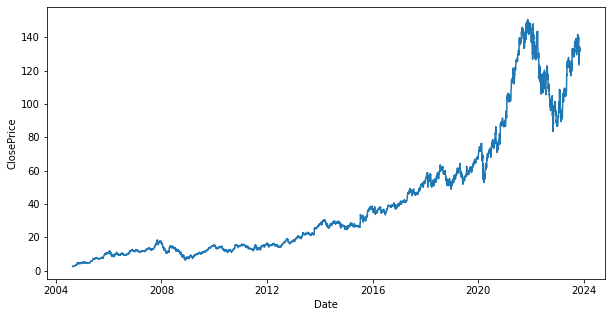

In [3]:
# グラフ表示
plt.figure(figsize = (10, 5))
plt.plot(df["Date"].to_numpy(), df["Adj Close"].to_numpy())
plt.xlabel("Date")
plt.ylabel("ClosePrice")
plt.show()

#### 1.1 前処理
株価データを取得した後は，前処理を行う．前処理とは，データを機械学習アルゴリズムに適した形に整理・加工することである．<br>
具体的には，以下のような作業を行います．それでは，以下のコードで前処理を行いましょう．
- 欠損値の処理:
    - データに欠損値（NaN）がある場合，それを埋めるか，削除する．
- データの正規化:
    - データのスケールを統一する．
- 特徴量エンジニアリング
    - 有用な特徴量を生成する．

In [4]:
# 必要なライブラリのインポート
from sklearn.preprocessing import MinMaxScaler  # データ正規化

# 欠損値の処理
df=df.dropna()

# データの正規化
scaler = MinMaxScaler()
df["Adj Close"] = scaler.fit_transform(df[["Adj Close"]])

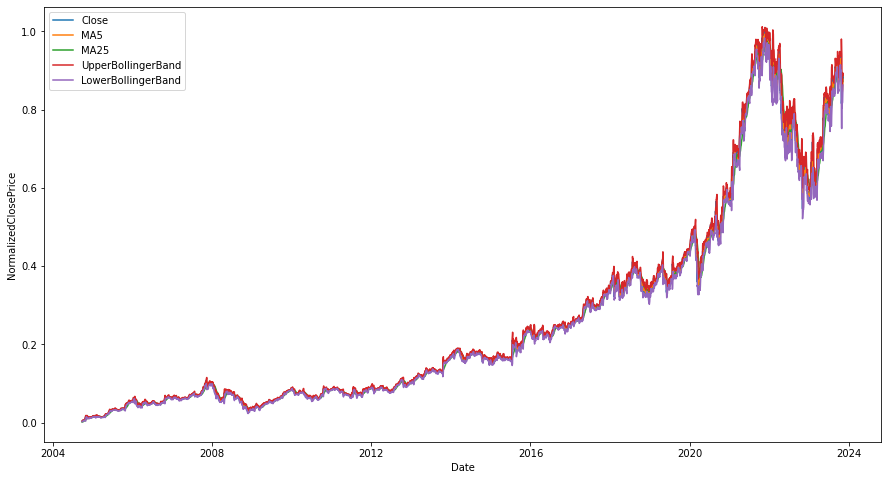

In [5]:
# 特徴量エンジニアリング
# 5日移動平均
df["MA5"] = df["Adj Close"].rolling(window = 5).mean()
# 25日移動平均
df["MA25"] = df["Adj Close"].rolling(window = 25).mean()

# ボリンジャーバンド
df["UpperBB"] = df["MA5"] + 2 * df["Adj Close"].rolling(window=5).std()
df["LowerBB"] = df["MA5"] - 2 * df["Adj Close"].rolling(window=5).std()

# 欠損値の削除
df = df.dropna()

# グラフ表示
plt.figure(figsize = (15, 8))
plt.plot(df["Date"].to_numpy(), df["Adj Close"].to_numpy(), label = "Close")
plt.plot(df["Date"].to_numpy(), df["MA5"].to_numpy(), label = "MA5")
plt.plot(df["Date"].to_numpy(), df["MA25"].to_numpy(), label = "MA25")
plt.plot(df["Date"].to_numpy(), df["UpperBB"].to_numpy(), label = "UpperBollingerBand")
plt.plot(df["Date"].to_numpy(), df["LowerBB"].to_numpy(), label = "LowerBollingerBand")
plt.xlabel("Date")
plt.ylabel("NormalizedClosePrice")
plt.legend()
plt.show()

### 2. 機械学習モデルの作成
#### 2.1 教師データとテストデータの分割
まず，株価データを教師データ（学習用データ）とテストデータ（評価用データ）に分割する． <br>
機械学習モデルを作成する際には，モデルの性能を評価するために，データを学習用と評価用に分けるのが一般的である． <br>
<br>
株価データのような時系列データの場合，シャッフルせずにデータを分割することで，未来のデータを使って過去のデータを予測するという現実にそぐわない状況を防ぐ． <br>
時系列データの分割では，過去のデータを使って未来のデータを予測することが重要．

In [6]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split

# 特徴量と目的変数の準備
X = df[["MA5", "MA25", "UpperBB", "LowerBB"]].values
y = df["Adj Close"].values

# 教師データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

#### 2.2 モデルの選択と学習
機械学習モデルを選択し，学習させてみましょう． <br>
今回は，線形回帰モデルを使って株価予測を行う．線形回帰モデルは，特徴量と目的変数の関係を線形な式で表現し，最適な係数を求めることで予測を行うモデルである．


In [7]:
# 必要なライブラリ（線形回帰）のインポート
from sklearn.linear_model import LinearRegression

# モデルの選択
model = LinearRegression()
# モデルの学習
model.fit(X_train, y_train)

LinearRegression()

#### 2.3 モデルの評価
学習したモデルの性能を評価する．今回は，平均二乗誤差（MeanSquaredError,MSE）と決定係数（R2スコア）を使って評価していく． <br>
- MSE :
  - 予測誤差の二乗の平均で，値が小さいほど性能が良いことを示す．
- R2スコア :
  - 0から1の範囲の値をとり，1に近いほど性能が良いことを示す．


In [8]:
# 必要なライブラリ（線形回帰の評価）のインポート
from sklearn.metrics import mean_squared_error, r2_score

# 予測値の計算
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 評価指標の計算
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)

# 結果の出力
print(f"MSE(Train) : {mse_train:.4f}")
print(f"MSE(Test) : {mse_test:.4f}")
print(f"R^2Score(Train) : {r2_train:.4f}")
print(f"R^2Score(Test) : {r2_test:.4f}")

MSE(Train) : 0.0000
MSE(Test) : 0.0002
R^2Score(Train) : 0.9992
R^2Score(Test) : 0.9919


#### 2.4 予測結果の可視化
最後に，予測結果をグラフで表示してみる．これによって，モデルが実際にどのように株価を予測しているのかを視覚的に理解することができる．　<br>
<br>
線形回帰モデルは単純なモデルのため，実際の株価予測には限界がある．より高度な予測を行うには，ディープラーニングなどの複雑なモデルを用いることが必要．

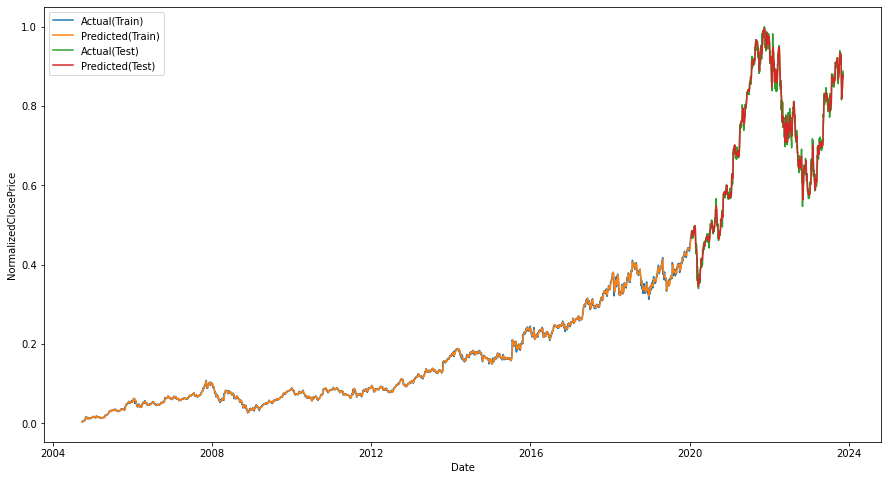

In [9]:
plt.figure(figsize = (15, 8))
plt.plot(df["Date"][:len(y_train)].to_numpy(), y_train, label="Actual(Train)")
plt.plot(df["Date"][:len(y_train_pred)].to_numpy(), y_train_pred, label = "Predicted(Train)")
plt.plot(df["Date"][len(y_train):].to_numpy(), y_test, label = "Actual(Test)")
plt.plot(df["Date"][len(y_train_pred):].to_numpy(), y_test_pred, label = "Predicted(Test)")
plt.xlabel("Date")
plt.ylabel("NormalizedClosePrice")
plt.legend()
plt.show()


### 3. ディープラーニングを使った株式予測
#### 3.1 LSTMモデルの構築
長短期記憶（LongShort-TermMemory,LSTM）というリカレントニューラルネットワーク（RNN）の一種を使ってみる．LSTMは時系列データを扱うのに適したモデルである．

In [10]:
# 必要なライブラリのインポート
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# 時系列データを生成する関数
def create_sequences(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys. append( y[ i + time_steps])

    return np.array(Xs), np.array(ys)


# ハイパーパラメータ
time_steps = 10

# 時系列データの生成
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

# LSTMモデルの構築
model = Sequential()
model.add(LSTM(50, activation = "relu", input_shape = (time_steps, 4)))
model.add(Dense(1))
model.compile(
    optimizer = Adam(
                    learning_rate = 0.001
                    ),
    loss = "mean_squared_error"
)


# モデルの学習
model.fit(X_train_seq, y_train_seq, epochs = 100, batch_size = 32, verbose = 0)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

In [14]:
# 予測値の計算
y_train_pred_lstm = model.predict(X_train_seq)
y_test_pred_lstm = model.predict(X_test_seq)

# 評価指標の計算
mse_train_lstm = mean_squared_error(y_train_seq, y_train_pred_lstm)
mse_test_lstm = mean_squared_error(y_test_seq, y_test_pred_lstm)
r2_train_lstm = r2_score(y_train_seq, y_train_pred_lstm)
r2_test_lstm = r2_score(y_test_seq, y_test_pred_lstm)

# 結果の確認
print(f"MSE (Train, LSTM): {mse_train_lstm : .4f}")
print(f"MSE (Test, LSTM): {mse_test_lstm : .4f}")
print(f"R^2 Score (Train, LSTM): {r2_train_lstm : .4f}")
print(f"R^2 Score (Test, LSTM): {r2_test_lstm : .4f}")

30/30 [==============================] - 0s 5ms/step
MSE (Train, LSTM):  0.0000
MSE (Test, LSTM):  0.0004
R^2 Score (Train, LSTM):  0.9983
R^2 Score (Test, LSTM):  0.9876


最後に，予測結果をグラフで表示してみる． <br>
LSTMは時系列データを扱うのに適したモデルであるため，線形回帰モデルよりも高い予測性能を発揮している．ただし，株価予測は非常に難しい問題であり，どのようなモデルでも完璧な予測ができるわけではない． <br>
また，過去のデータに過度に依存しないように注意することも大切．


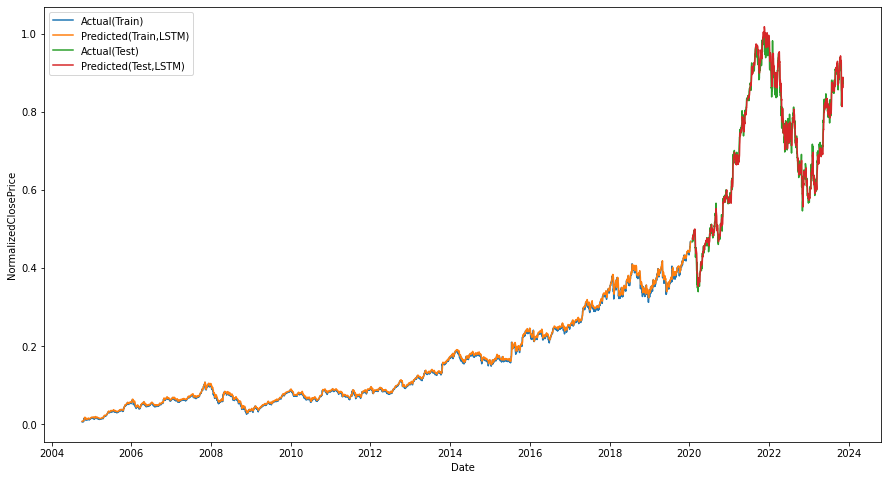

In [28]:
# 結果を可視化
plt.figure(figsize = (15, 8))
plt.plot(df["Date"][time_steps : len(y_train_seq) + time_steps], y_train_seq, label="Actual(Train)")
plt.plot(df["Date"][time_steps : len(y_train_pred_lstm) + time_steps], y_train_pred_lstm, label = "Predicted(Train,LSTM)")
plt.plot(df["Date"][len(y_train_seq) + 2 * time_steps :], y_test_seq, label = "Actual(Test)")
plt.plot(df["Date"][len(y_train_pred_lstm) + 2 * time_steps :], y_test_pred_lstm, label = "Predicted(Test,LSTM)")
plt.xlabel("Date")
plt.ylabel("NormalizedClosePrice")
plt.legend()
plt.show()


### まとめ
今回学習したことをまとめておく．

- 株価予測は，過去の株価データをもとに未来の株価を予測する問題です．
- データの前処理では，欠損値の処理や正規化などを行います．
- 特徴量エンジニアリングで，新たな特徴量を作成し，モデルの予測性能を向上させることができます．
- 機械学習モデルを選択し，学習データを用いてモデルを学習させます．評価指標を用いてモデルの性能を評価し，予測結果を可視化します．
- 線形回帰モデルはシンプルなモデルであり，ある程度の予測ができますが，限界があります．
- ディープラーニングを使った株価予測では，LSTMなどの時系列データに適したモデルを用いることで，より高い予測性能を発揮することが期待できます．